In [9]:
import wandb
# Log in to your W&B account
!wandb login **************

wandb.init(project="*****", entity="********")

import os 
import os.path as osp
import math
import time
import pandas as pd
import numpy as np
import cv2

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter

from wandb.lightgbm import wandb_callback
import lightgbm as lgb

import re

ROOTPH = '/Users/Karen/Documents/PSPNet/dataset_ex'
TRAIN_TXT = '/ImageSets/Segmentation/train.txt'
VAL_TXT = '/ImageSets/Segmentation/val.txt'
EPOCH = 3 #通常は１５epoch だが、お試し用で３epochにしています。バッチ設定も同様です。
BACH = 3
'''
BACH_TRAIN = 1 #8
#MINI_BACH_TRAIN = 4
BACH_VAL = 1 #4
#MINI_BACH_VAL = 2
'''
STADY_IMAGE = 'stady_image'
WIGHTS_FILE = ''

"""ファイルのパスリストの作成"""
def make_datapath_list(rootpath):
    '''
    学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    '''

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template_train = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    imgpath_template_val = osp.join(rootpath, 'JPEGImages', '%s.jpg')

    annopath_template_train = osp.join(rootpath, 'SegmentationClassPNG', '%s.png')
    annopath_template_val = osp.join(rootpath, 'SegmentationClassPNG', '%s.png')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + TRAIN_TXT)
    val_id_names = osp.join(rootpath + VAL_TXT) 

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template_train % file_id)  # 画像のパス
        anno_path = (annopath_template_train % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template_val % file_id)  # 画像のパス
        anno_path = (annopath_template_val % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list

#前処理
class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, input_size):
        self.data_transform = {
            'train': Compose([
                Resize_Totensor(input_size)
            ]),
            'val': Compose([
                Resize_Totensor(input_size)
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)

class Compose(object):#data_augumentation.py
    """引数transformに格納された変形を順番に実行するクラス
       対象画像とアノテーション画像を同時に変換させます。 
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, anno_class_img):
        for t in self.transforms:
            img, anno_class_img= t(img, anno_class_img)
        return img, anno_class_img

class Resize_Totensor(object):#data_augumentation.py
    """引数input_sizeに大きさを変形するクラス"""

    def __init__(self, input_size):
        self.input_size = input_size

    def __call__(self, img, anno_class_img):

        # width = img.size[0]  # img.size=[幅][高さ]
        # height = img.size[1]  # img.size=[幅][高さ]
        
        img = img.resize((self.input_size, self.input_size),
                         Image.BICUBIC)
                         #C：\ Users \ Karen \ AppData \ Local \ Temp \ ipykernel_14080 \ 1979944108.py：114：非推奨警告：BICUBICは非推奨であり、Pillow 10（2023-07-01）で削除されます。
        anno_class_img = anno_class_img.resize(
            (self.input_size, self.input_size), Image.NEAREST)
        
        img = torch.from_numpy(np.array(img, dtype=float).transpose(2,0,1)) / 255

        anno_class_img = np.array(anno_class_img)
        index = np.where(anno_class_img == 255)
        anno_class_img[index] = 1
        anno_class_img = torch.from_numpy(anno_class_img)

        #width = img.size[0]  # img.size=[幅][高さ]
        #height = img.size[1]  # img.size=[幅][高さ]

        return img, anno_class_img


#Datasetの作成
class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
    
    def __path__(self):
        '''パスを返す'''
        return self.img_list
    
    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとアノテーションを取得
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーションを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [高さ][幅][色RGB]

        # 2. アノテーション画像読み込み
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅]

        # 3. 前処理を実施
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img


class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()

        # パラメータ設定
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_sizeの1/8に

        # 4つのモジュールを構成するサブネットワークの用意
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Featureモジュールの途中をAuxモジュールへ

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)


class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplase設定で入力を保存せずに出力を計算し、メモリ削減する

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)

        return outputs


class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''構成するネットワークを用意'''
        super(FeatureMap_convolution, self).__init__()

        # 畳み込み層1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling層
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs


class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSPの用意
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSPの繰り返しの用意
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )


class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs


class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # スキップ結合
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)


class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)


class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        # 各畳み込み層の出力チャネル数
        out_channels = int(in_channels / len(pool_sizes))

        # 各畳み込み層を作成
        # この実装方法は愚直すぎてfor文で書きたいところですが、分かりやすさを優先しています
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 最終的に結合させる、dim=1でチャネル数の次元で結合
        output = torch.cat([x, out1, out2, out3, out4], dim=1)

        return output


class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output


class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

class PSPLoss(nn.Module):
    """PSPNetの損失関数のクラスです。"""

    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight  # aux_lossの重み

    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 475]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')
        
        return loss+self.aux_weight*loss_aux

class PSPrate():

    def __init__(self):
        self.train_result_img = 0
        self.val_result_img = 0

    def pixcel_count(self, outputs, target, phase):


        device2 = torch.device('cpu')

        output = outputs[0]#AuxLoss側は無視　yサイズはtorch.Size()
        output = output.to(device2)#CPU／GPUの切り替え
        target = target.to(device2)#CPU／GPUの切り替え
        TPFN_array = []

        with torch.no_grad():
            for i in range(len(output)):

                true_positive = 0
                true_negative = 0
                false_positive = 0
                false_negative = 0

                out_img = output[i, :, :, :].numpy()
                out_img = np.argmax(out_img, axis=0)#一番大きい要素のインデックスを返す(ピクセル毎に確信度が最大のクラスを求める。ここで８枚の画像からの学習結果が1枚でる。
                tar_img = target[i, :, :].numpy()

                for x in range(475):
                    for y in range(475):
                        if out_img[x,y] == 1 and tar_img[x,y] == 1:
                            true_positive += 1
                        elif out_img[x,y] == 1 and tar_img[x,y] == 0:
                            false_positive += 1
                        elif out_img[x,y] == 0 and tar_img[x,y] == 1:
                            true_negative += 1
                        elif out_img[x,y] == 0 and tar_img[x,y] == 0:
                            false_negative += 1
                
                TPFN_array.append([true_positive,true_negative,false_positive,false_negative])
                
        train_class_img = Image.fromarray(255-np.uint8(out_img)*255, mode="P")#(out_img[i]*255).astype(np.uint8)
        train_class_img.putpalette([255,255,0])#黄色に設定
        train_class_img = train_class_img.convert('RGB')
        #plt.imshow(train_class_img)
        #plt.show()
        anno_class_img = Image.fromarray(255-np.uint8(tar_img)*255, mode="P")#(tar_img[j]*255).astype(np.uint8)#黒白反転
        anno_class_img = anno_class_img.resize((475, 475), Image.NEAREST)
        anno_class_img.putpalette([0,255,255])#黄色に設定
        anno_class_img = anno_class_img.convert('RGB')
        #plt.imshow(anno_class_img)
        #plt.show()
        
        result_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
        
        for x in range(475):
            for y in range(475):
                #学習結果画像とアノテーションデータ画像のピクセルデータを取得
                ##黄色(学習結果)
                pixel_show = train_class_img.getpixel((x, y))
                #print(pixel_show)
                ##青色(作成したアノテーションデータ)
                pixel = anno_class_img.getpixel((x, y))
                #print(pixel)
        
                if pixel == (0, 255,255):#作成したアノテーションデータ
                    if pixel_show == (255, 255, 0):#学習結果画像
                        result_img.putpixel((x, y), (255, 255, 0, 150))#yellow
                        continue
                    else:
                        result_img.putpixel((x, y), (0, 255, 255, 150))#aqua
                        continue
                else:
                    if pixel_show == (255, 255, 0):#学習結果画像
                        result_img.putpixel((x, y), (255, 0, 0, 150))#red              
                        continue
                    else:
                        #black
                        continue
        
            if phase == 'train':
                self.train_result_img = result_img
            else:
                self.val_result_img = result_img

        return  TPFN_array

    def pspresult(self,tp,tn,fp,fn,phase):


        if (tp+tn+fp+fn) != 0:
            wandb.log({'正解率・正確さ('+phase+')':(tp+tn)/
                            (tp+tn+fp+fn)*100})
        else:
            wandb.log({'正解率・正確さ('+phase+')':0})
        '''
        全体のデータの中で正しく分類できたTP とTNがどれだけあるかという指標。
        '''

        if (tp+fp) != 0:
            wandb.log({'精度・適合率('+phase+')':tp/(tp+fp)*100})
        else:
            wandb.log({'精度・適合率('+phase+')':0})
        '''
        Positive と分類されたデータ(TP + FP)の中で実際にPositiveだったデータ(TP)数の割合。
        '''

        if (tp+fn) != 0:
            wandb.log({'再現率・真陽性率('+phase+')':tp/(tp+fn)*100})
        else:
            wandb.log({'再現率・真陽性率('+phase+')':0})
        '''
        取りこぼし無くPositive なデータを正しくPositiveと推測できているかどうか。
        '''

        if (fp+tn) != 0:
            wandb.log({'真陰性率('+phase+')':tn/(fp+tn)*100})
        else:
            wandb.log({'真陰性率('+phase+')':0})
        '''
        取りこぼし無くNegative なデータを正しくNegativeと推測できているかどうか。
        '''

        if (tp+fn) != 0:
            wandb.log({'偽陰性率('+phase+')':fn/(tp+fn)*100})
        else:
            wandb.log({'偽陰性率('+phase+')':0})
        '''
        実際にはPositive であるサンプルの内、Negativeであると判定されたクラスの割合。
        '''

        if (fp+tn) != 0:
            wandb.log({'偽陽性率('+phase+')':fp/(fp+tn)*100})
        else:
            wandb.log({'偽陽性率('+phase+')':0})
        '''
        実際にはNegative であるサンプルの内、Positiveであると判定されたクラスの割合。
        '''

        return  True

def psp_result_img(epoch,create_rate,imges,phase,subset_count):

    if phase == 'train':
        pix_img = create_rate.train_result_img
    else:
        pix_img = create_rate.val_result_img

    img = Image.fromarray((imges*255).astype(np.uint8))
    result_img = Image.alpha_composite(img.convert('RGBA'), pix_img)
    result_img = cv2.cvtColor(np.asarray(result_img), cv2.COLOR_RGBA2BGRA)
    plt.imshow(result_img)
    plt.show()
    cv2.imwrite(ROOTPH+'/'+STADY_IMAGE+'/epoch'+str(epoch)+'_'+phase+'_subset'+str(subset_count)+'.jpg', result_img)

    return True


def train_model(net, dataloaders_dict, criterion, create_rate, scheduler, optimizer, num_epochs):

    train_loss_list = []
    val_loss_list = []
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    print(torch.cuda.is_available())

    # ネットワークをGPUへ
    net.to(device)
    print(net)
    #summary(net,([8, 3, (475,475)]))

    # ネットワークがある程度固定であれば、高速化させる
    #torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = BACH #3

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:

            batch_size = dataloaders_dict[phase].batch_size
            
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                optimizer.zero_grad()# 最適化schedulerの更新
                optimizer.step()#PyTorch 1.1.0以降では、逆の順序で呼び出す必要
                scheduler.step()  
                
                print('（train）')

            else:
                net.eval()   # モデルを検証モードに
                print('-------------')
                print('（val）')

            count = 0  # multiple minibatch
            subset_count = 0
            # データローダーからminibatchずつ取り出すループ
            for imges, anno_class_imges in dataloaders_dict[phase]:

                    imges_len = len(imges)
                    img_stock = []
                    for r in range(imges_len):
                        
                        img = imges[r, :, :, :].numpy().transpose(2, 1, 0)
                        img = np.fliplr(img)
                        img = np.rot90(img, 1)

                        if r == imges_len-1:
                            picup_img = img

                        img = img.transpose(2, 1, 0)
                        new_imge = torch.from_numpy(img.astype(np.float64)).clone()
                        img_stock.append(new_imge)
                        
                    new_imges = torch.stack(img_stock)
                    
                    #plt.imshow(new_imges[r, :, :, :].numpy().transpose(2, 1, 0))
                    #plt.show()
                    
                    # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                    if new_imges.size()[0] == 1:
                        continue

                    # GPUが使えるならGPUにデータを送る
                    new_imges = new_imges.to(device, dtype=torch.float)
                    anno_class_imges = anno_class_imges.to(device, dtype=torch.float)

                    
                    # multiple minibatchでのパラメータの更新
                    if (phase == 'train') and (count == 0):
                        optimizer.step()
                        optimizer.zero_grad()
                        count = batch_multiplier


                    # 順伝搬（forward）計算
                    with torch.set_grad_enabled(phase == 'train'):

                        outputs = net(new_imges)
                        
                        loss = criterion(outputs, anno_class_imges.long()) / batch_multiplier#anno_class_imgesを１０進数に変換

                        tpft_array = create_rate.pixcel_count(outputs, anno_class_imges, phase)
                        

                        # 訓練時はバックプロパゲーション
                        if phase == 'train':

                            # 勾配の計算
                            loss.backward()

                            # multiple minibatch
                            count -= 1

                            #学習対象の画像の表示
                            psp_result_img(epoch,create_rate,picup_img,'train',subset_count)
                            subset_count += 1

                            #グラフ化
                            for tpft in tpft_array:
                                create_rate.pspresult(tpft[0],tpft[1],tpft[2],tpft[3],'train')
                            

                            if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                                t_iter_finish = time.time()
                                duration = t_iter_finish - t_iter_start
                                print('Iteration {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(iteration, 
                                                                loss.item()/batch_size*batch_multiplier, duration))
                                t_iter_start = time.time()
                                epoch_train_loss += loss.item() * batch_multiplier
                                iteration += 1

                        # 検証時
                        else:

                            epoch_val_loss += loss.item() * batch_multiplier

                            #学習対象の画像の表示
                            psp_result_img(epoch,create_rate,picup_img,'val',subset_count)
                            subset_count += 1

                            #グラフ化
                            for tpft in tpft_array:
                                create_rate.pspresult(tpft[0],tpft[1],tpft[2],tpft[3],'val')

            # epochのphaseごとのlossと正解率
            t_epoch_finish = time.time()
            print('-------------')
            print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
                epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
            print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
            t_epoch_start = time.time()

            #lossの可視化のリスト
            train_loss_list.append(epoch_train_loss/num_train_imgs)
            val_loss_list.append(epoch_val_loss/num_val_imgs)
            if ((epoch+1) % 5 == 0):
                torch.save(net.state_dict(), ROOTPH + '/weights/pspnet50_' + str(epoch+1) + '.pth')
                # ログを保存
            log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                        num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}

            #weight_log
            wandb.log(log_epoch)
            logs.append(log_epoch)
            df = pd.DataFrame(logs)
            df.to_csv("log_output.csv")

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), ROOTPH + '/weights/'+WIGHTS_FILE+'/pspnet50_' + str(epoch+1) + '.pth')
    return train_loss_list, val_loss_list

#ファイルのパスリストを作成
rootpath = ROOTPH
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])
print(val_img_list[0])
print(val_anno_list[0])

#PSPnetの用意
net = PSPNet(n_classes = 150) #150 or 2
state_dict = torch.load(ROOTPH + "/weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict)
#n_classes = 2
#net.decode_feature.classification = nn.Conv2d(in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)
#net.aux.classification = nn.Conv2d(in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)
#レイヤー確認

#summary(net, input_size=(2,1,3))#input_size=(out_channels,H,W)

""" データセット作成"""
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475))
'''
print('データの取り出し例')
print("例１",train_dataset.__getitem__(0)[1].shape)
print("例２",val_dataset.__getitem__(0)[1].shape)
print("例３",val_dataset.__getitem__(0)[1])
'''

"""データローダーの作成"""
batch_size= BACH#ミニバッチのサイズを指定

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
imges, anno_class_imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475])

criterion = PSPLoss(aux_weight=0.4)
create_rate = PSPrate()

#スケジューラーを利用したepochごとの学習の変更
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)

# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 400
    return math.pow((1-epoch/max_epoch), 0.9)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Karen/.netrc


epoch,▁▁▅▅██
train_loss,▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁
epoch,3
train_loss,0.0
val_loss,0.0


/Users/Karen/Documents/PSPNet/dataset_ex\JPEGImages\DJI_0001.jpg
/Users/Karen/Documents/PSPNet/dataset_ex\SegmentationClassPNG\DJI_0001.png
/Users/Karen/Documents/PSPNet/dataset_ex\JPEGImages\DJI_0002.jpg
/Users/Karen/Documents/PSPNet/dataset_ex\SegmentationClassPNG\DJI_0002.png


C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:159: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:162: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  (self.input_size, self.input_size), Image.NEAREST)


torch.Size([2, 3, 475, 475])
torch.Size([2, 475, 475])


使用デバイス： cuda:0
True
PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
   

C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:159: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:162: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  (self.input_size, self.input_size), Image.NEAREST)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:578: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  anno_class_img = anno_class_img.resize((475, 475), Image.NEAREST)


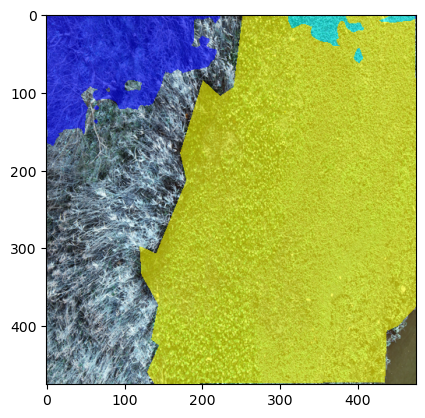

-------------
epoch 1 || Epoch_TRAIN_Loss:0.0000 ||Epoch_VAL_Loss:0.0000
timer:  12.4064 sec.
-------------
（val）


C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:159: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:162: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  (self.input_size, self.input_size), Image.NEAREST)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:578: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  anno_class_img = anno_class_img.resize((475, 475), Image.NEAREST)


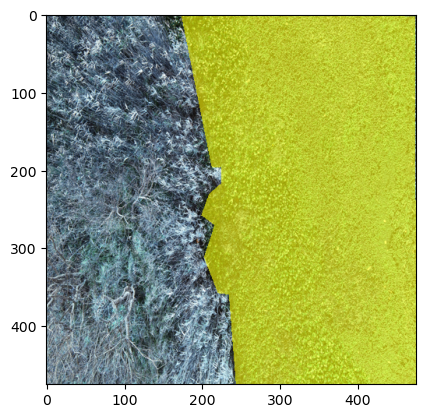

-------------
epoch 1 || Epoch_TRAIN_Loss:0.0000 ||Epoch_VAL_Loss:9.6628
timer:  2.3964 sec.
-------------
Epoch 2/3
-------------
（train）


C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:159: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:162: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  (self.input_size, self.input_size), Image.NEAREST)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:578: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  anno_class_img = anno_class_img.resize((475, 475), Image.NEAREST)


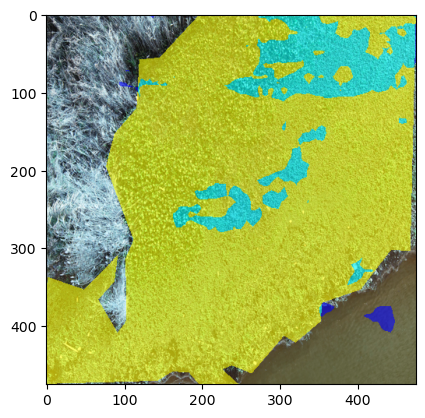

-------------
epoch 2 || Epoch_TRAIN_Loss:0.0000 ||Epoch_VAL_Loss:0.0000
timer:  2.5479 sec.
-------------
（val）


C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:159: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:162: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  (self.input_size, self.input_size), Image.NEAREST)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:578: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  anno_class_img = anno_class_img.resize((475, 475), Image.NEAREST)


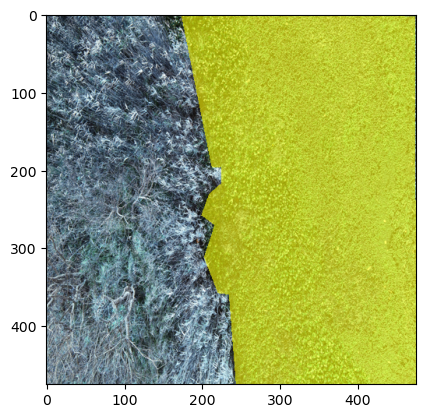

-------------
epoch 2 || Epoch_TRAIN_Loss:0.0000 ||Epoch_VAL_Loss:9.0628
timer:  2.2923 sec.
-------------
Epoch 3/3
-------------
（train）


C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:159: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:162: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  (self.input_size, self.input_size), Image.NEAREST)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:578: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  anno_class_img = anno_class_img.resize((475, 475), Image.NEAREST)


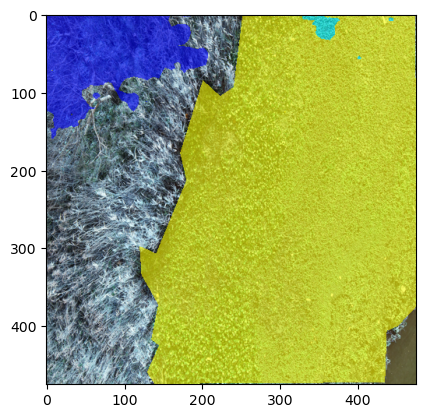

-------------
epoch 3 || Epoch_TRAIN_Loss:0.0000 ||Epoch_VAL_Loss:0.0000
timer:  2.6106 sec.
-------------
（val）


C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:159: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  Image.BICUBIC)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:162: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  (self.input_size, self.input_size), Image.NEAREST)
C:\Users\Karen\AppData\Local\Temp\ipykernel_11856\3107118946.py:578: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  anno_class_img = anno_class_img.resize((475, 475), Image.NEAREST)


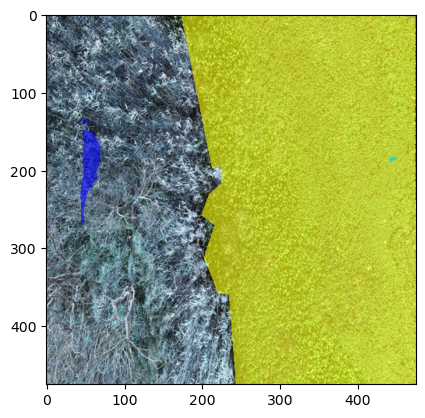

-------------
epoch 3 || Epoch_TRAIN_Loss:0.0000 ||Epoch_VAL_Loss:3.5230
timer:  2.2069 sec.


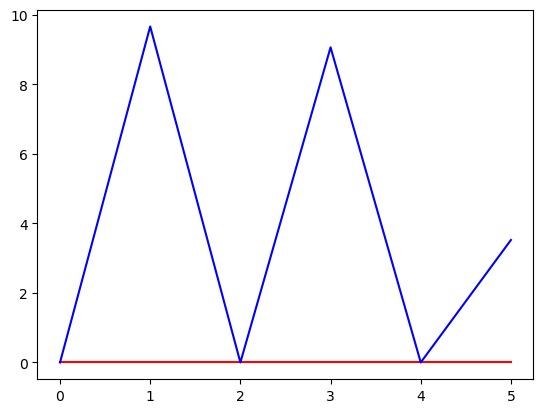

In [10]:
#学習・検証を実行する
num_epochs = EPOCH
train_loss_list, val_loss_list = train_model(net, dataloaders_dict, criterion, create_rate, scheduler, optimizer, num_epochs)

plt.plot(train_loss_list, color='red')
plt.plot(val_loss_list, color='blue')
plt.show()